## Поиск источника девиаций по данным Splunk

In [10]:
import splunklib
import splunklib.client as client
import splunklib.results as results

import datetime as dt
from time import sleep

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
#Подключение

HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

In [3]:
#Создаем необходимые процедуры

log_level = 0

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

In [4]:
#Указываем время, запрос и запускаем запрос

dateFrom = dt.datetime.strptime('2018-04-12T08:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = dt.datetime.strptime('2018-04-13T08:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr (4250196* OR 26006*) PROTOCOL=S6a ANS_RES_CODE=2001
| eval CODE_TEMP=case(isnotnull(ANS_RES_CODE),ANS_RES_CODE,isnull(ANS_RES_CODE), ANS_EXP_RES_CODE, isnull(ANS_EXP_RES_CODE), EXP_RES_CODE, isnull(EXP_RES_CODE), RES_CODE)
| eval CODE=if(isnotnull(CODE_TEMP), CODE_TEMP, "PUR_NOR") | eval CUSTOMER=coalesce(THIRD_PARTY,MVNO)
| Timechart span=15m count by CUSTOMER  | table *
'''

In [5]:
## Исправленный вариант на основе:
#http://docs.splunk.com/DocumentationStatic/PythonSDK/1.6.3/client.html#splunklib.client.Job.results

bEchoTime = False

sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
kwargs_export = {"earliest_time": sfrom,
                 "latest_time":sto ,
                 "search_mode": "normal",
                 #"output_mode":"JSON",
                 #"rf" : fields,
                 "supports_multivalues":True
                 }

job = service.jobs.create(searchquery_export, **kwargs_export)
while not job.is_done():
    sleep(.2)
rr = results.ResultsReader(job.results())

outputResult = list()
i=0

for result in rr:
            if isinstance(result, dict):
                outputResult.append(result)
assert rr.is_preview == False

df=DataFrame(outputResult)
df.tail()

,C9,MB,Mondicon,NAKA,OTHER,PuertoSeguro,Rewicom,Roamability,Telzar,TinkLab,Tinklabs,_span,_time
91,636,405,144,1566,0,14,0,170,2135,0,558,900,2018-04-13T06:45:00.000+02:00
92,842,458,160,1626,0,3,1,167,2238,4,3643,900,2018-04-13T07:00:00.000+02:00
93,803,272,151,1728,0,9,1,164,2247,0,745,900,2018-04-13T07:15:00.000+02:00
94,851,408,147,1841,0,13,0,168,2241,0,468,900,2018-04-13T07:30:00.000+02:00
95,931,463,123,1842,0,27,0,171,2347,0,226,900,2018-04-13T07:45:00.000+02:00


<IPython.core.display.Javascript object>


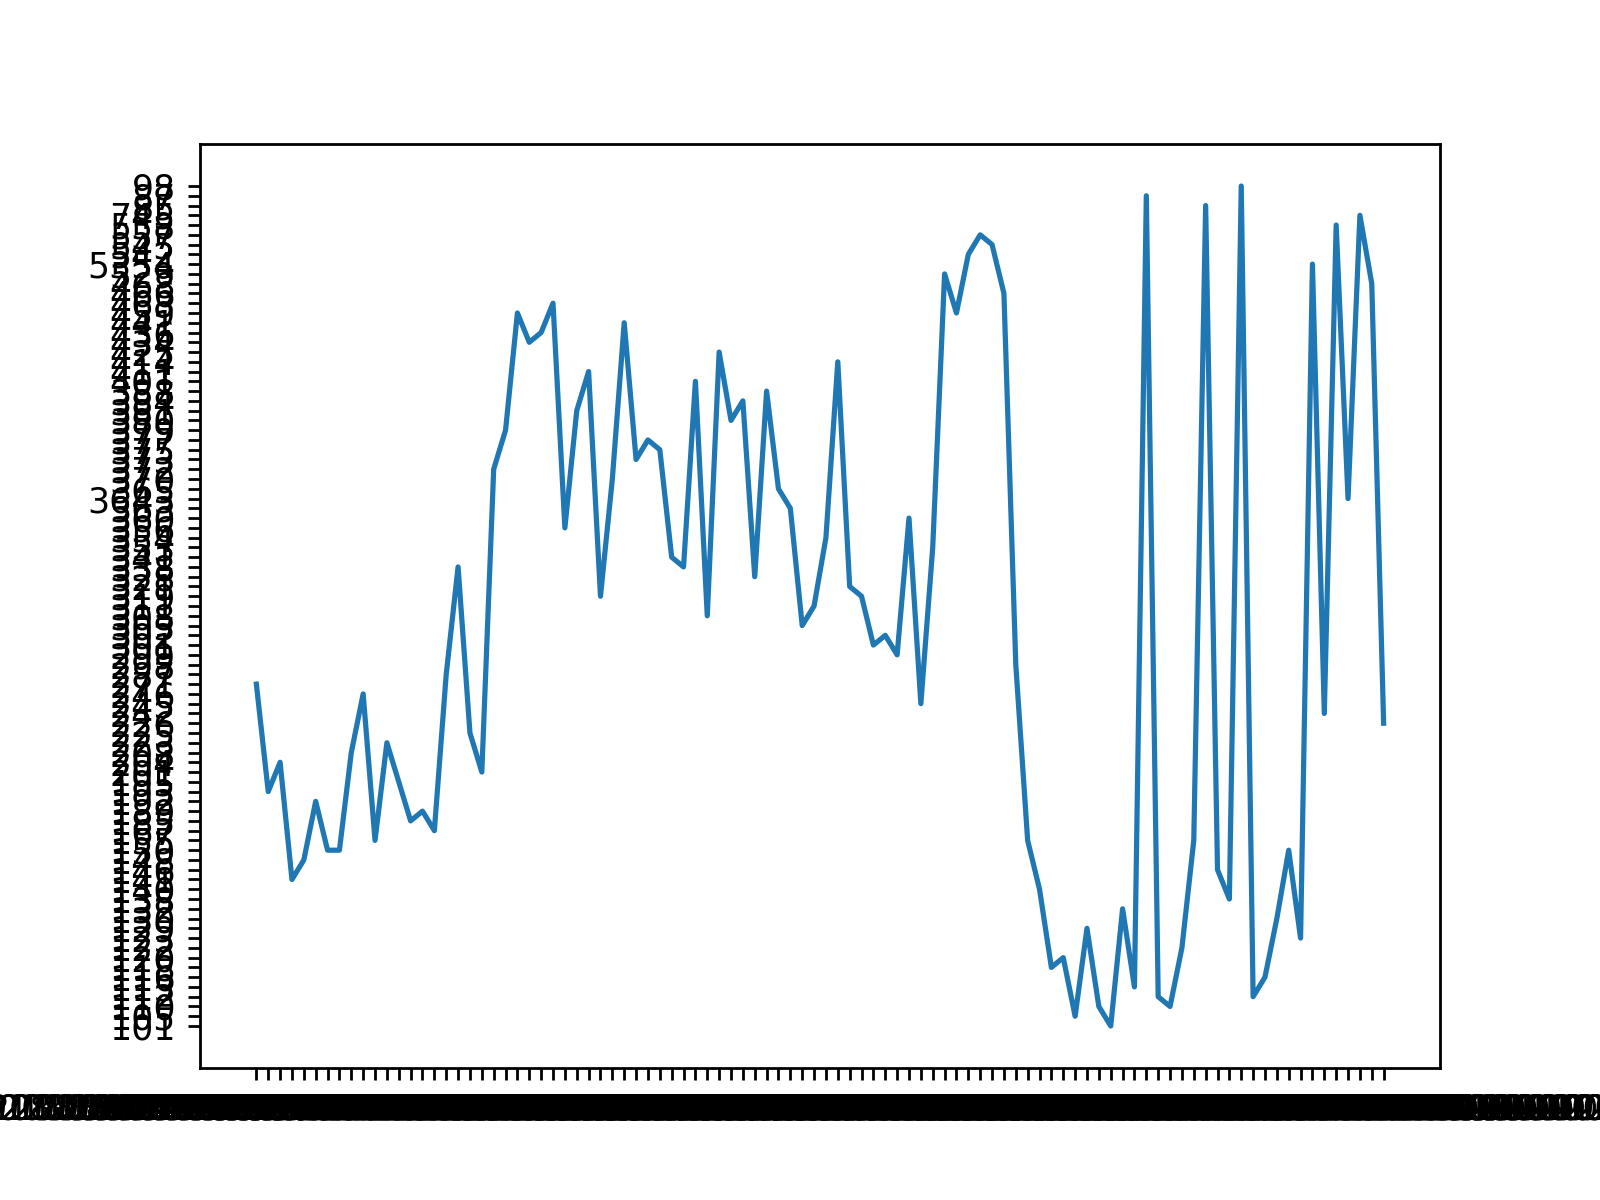

In [11]:
plt.plot(df['_time'],df['Tinklabs'])
plt.show()